In [1]:
import femm 
import time
import random
from tqdm import tqdm_notebook as vs
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
from math import atan,sin,cos,pi
from IPython.display import Image as pic_show

In [17]:
a = np.random.random(10).reshape(5,2)
a[:,:]  -a[:,None]
hard[:,[0,1]] = hard[:,[1,0]]
.reshape(-1,2) 
np.random.random(10).reshape(-1,2)

## Оптимизация магнитной системы 

ГОСТ 22483-2012 "Жилы токопроводящие для кабелей, проводов и шнуров"

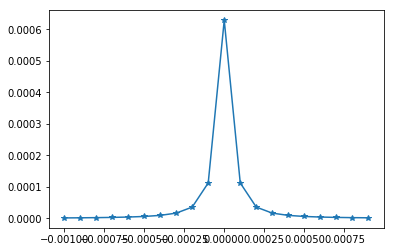

In [4]:
%matplotlib inline
Cu=[0.03,0.05,0.08,0.12,0.20,0.35,0.75] #сечения номинальные о ГОСТ
BS= lambda current,r,line,angle=0.5*pi:  (line*current*sin(angle)*1.25663706e-6 )/(4*pi*r**2)
BS(1,0.5e-3,pi*1e-3)
5*1.25663706e-3
y=[]
for i in range(-10,10):
    if i == 0:
        y+=[BS(1,5e-4,pi*5e-4)]
        
    else:
        a= i*1e-3
        alfa = atan(a/5e-4)
        r = a/sin(alfa)
        #print(180*alfa/pi)
        y+=[abs(BS(1,r,pi*5e-4,alfa))]
    
plt.plot([i*1e-4 for i in range(-10,10)],y,'*-')
plt.show()
a=2e-3
b=3.5e-3
hae= 1e-3
hz=0.2e-3
lzad= (0.5*(a-b) +a)*pi
#print(lzad)
alfa= atan((hae+2*hz)/a)
#print(alfa)
r=(0.5*hae+hz)/sin(alfa)
#print(r)
i=((1e7 )*1*r**2)/(lzad*sin(alfa))

## FEMM 


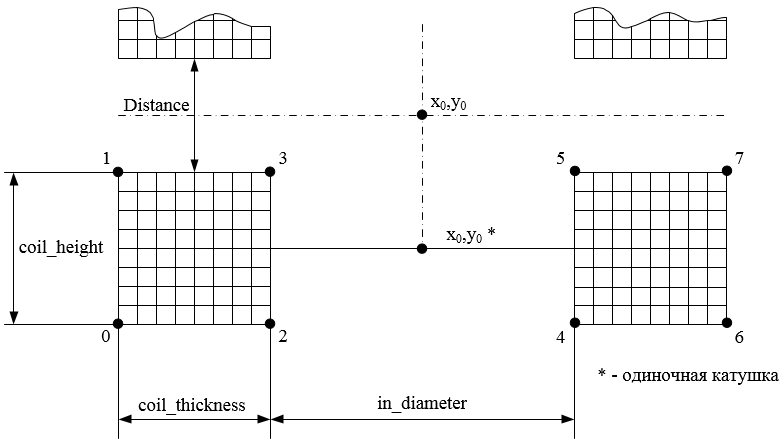

In [4]:
pic_show("fig\\Coil_dimensions.png")

## Деформация при стационарном магнитном поле

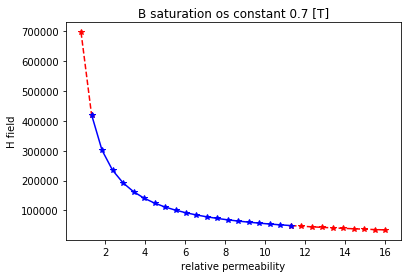

In [262]:
vacuum_permeability = 1.2566370614e-6
saturation = lambda relative_permeaility, B_saturation = 0.7:\
B_saturation/(vacuum_permeability*relative_permeaility)
H = np.linspace(0.8,16,30)
H_msm = H[np.logical_and(H>1 , H <11.3)]
H_low = H[H<1.4]
H_hight =H[H>11.2]
plt.plot(H_low,saturation(H_low),'r*--')
plt.plot(H_hight,saturation(H_hight),'r*--')
plt.plot(H_msm,saturation(H_msm),'b*-')
plt.xlabel('relative permeability')
plt.ylabel('H field')
plt.title('B saturation os constant 0.7 [T]')
plt.show()

<b>Синяя линия</b> это напряженость насыщения при индукции магнитного поля 
0.7 тесла, для диапазона магнитной проницаемости, тот диапазон в котором должна меняться
магнитная проницаемост материала  

In [24]:
class lamella:
   
    def __init__(self, x0=0, width=0.01, groups_list =[], new_lamella = True ):
        
        if groups_list == []:
            groups_list += [0, 1]
            n=0
        else:
            n = groups_list[-1] + 1
            groups_list += [n,n+1]
        
        self.x0 = x0
        self.left = [[x0-width*0.5,-0.5],[x0-width*0.5,0.5]]
        self.right = [[x0+width*0.5,-0.5],[x0+width*0.5,0.5]]
        self.groups_list_pointer = groups_list
        self.outer = [[x0-width/2.0-1e-3,0],[x0+width/2.0+1e-3,0]]
        self.left_group = n
        self.right_group = n+1
        
        if new_lamella:
            
            femm.mi_drawrectangle(*np.array([x0-width*0.5,-0.5,x0+width*0.5,0.5]))
            femm.mi_addblocklabel(*[x0,0]) 
            femm.mi_selectlabel(*[x0,0])
            femm.mi_setblockprop('Stretched_MSM', 0, 1, '<None>', 0, 0, 0)
            femm.mi_clearselected()
            [femm.mi_addblocklabel(*i) for i in self.outer]
            [femm.mi_selectlabel(*i) for i in self.outer]
            femm.mi_setblockprop('Compresed_MSM', 0, 1, '<None>', 0, 0, 0)
            femm.mi_clearselected()
            [femm.mi_selectnode(*i) for i in self.left] # left side 
            femm.mi_setgroup(n)
            femm.mi_clearselected()
            [femm.mi_selectnode(*i) for i in self.right] # right side
            femm.mi_setgroup(n+1)
            femm.mi_clearselected()
        
      
        
                
    def __add__(self, _lamella):
        #check right left lamella 
        
        if self.x0 < _lamella.x0:
            left = self
            right = _lamella
        else:
            left = _lamella
            right =  self
            
        femm.mi_selectlabel(*left.outer[1]) # delete right air label from left lamella
        femm.mi_selectlabel(*right.outer[0]) # same, left label from right lamella 
        femm.mi_selectlabel(*[right.x0,0]) # delete material label from right lamella  
        femm.mi_deleteselectedlabels()
        
        femm.mi_selectgroup(left.right_group)
        femm.mi_deleteselectednodes() 
        femm.mi_selectgroup(right.left_group)
        femm.mi_deleteselectednodes()
        
        self.groups_list_pointer.remove(left.right_group)
        self.groups_list_pointer.remove(right.left_group)
        
        femm.mi_addsegment(*left.left[0],*right.right[0])
        femm.mi_addsegment(*left.left[1],*right.right[1])
        
        new_lamella = lamella(new_lamella = False)
        new_lamella.x0 = (left.x0 + right.x0)/2.0
        new_lamella.left = left.left
        new_lamella.right = right.right
        new_lamella.groups_list_pointer =  self.groups_list_pointer
        new_lamella.outer = [left.outer[0],right.outer[1]]
        new_lamella.left_group = left.left_group
        new_lamella.right_group = right.right_group
        
        return new_lamella
    def move_boundary(self, dx=0,dy=0, side=False):
    # side False is left side True is right side 
    
        if side:
            grp = 'left_group'
            __outer = 0
            dx *=-1
        else:
            grp = 'right_group'
            __outer = 1

        femm.mi_selectlabel(*self.outer[__outer])
        femm.mi_seteditmode('blocks')
        femm.mi_movetranslate(dx,dy)
        femm.mi_clearselected()

        femm.mi_selectgroup(self.__dict__[grp])
        femm.mi_seteditmode('nodes')
        femm.mi_movetranslate(dx,dy)
        femm.mi_clearselected()

        
    def __str__(self):
        return f'left_edge:{self.left[1]}<- x0:{self.x0}-> right_edge:{self.right[1]} \n{self.left[0]}     right_edge:{self.right[0]}'


class opti_mag:
    
    #def __enter__(self):
    #    return self.file_obj
    def __exit__(self, type, value, traceback):
        femm.closefemm()
        
    def __init__(self, gap = 0.1, Wmc = 4.0, Hmc= 1, coil_thick = 0.2):
        femm.openfemm()
        femm.newdocument(0)
        femm.mi_probdef(0, 'millimeters', 'planar', 1.e-8, 0, 30);
        
        # geometry ########################
        self.gap = gap
        self.Wmc = Wmc
        self.Hmc = Hmc
        self.coil_thick = coil_thick
        boundary = np.array([- Wmc*1.5 if Wmc*3 > 8 else -8, -(0.5+gap+Hmc)]*2)
        boundary[2:4] *= -1
        pole_upper = np.array([-Wmc/2,gap+0.5,Wmc/2,gap+0.5+Hmc])
        pole_lower = pole_upper.copy()
        pole_lower *= -1
        coil =pole_upper.copy()
        coil[[0,2]] += [-coil_thick,coil_thick]
        _coil=coil.copy()
        _coil *=-1
        MSM = np.array([-self.Wmc*1.5 if self.Wmc*3 > 8 else -8, -0.5]*2)
        MSM[2:] *= -1 
        print(MSM)
        ########################################################################
        
        femm.mi_drawrectangle(*boundary)
        femm.mi_drawrectangle(*pole_upper)
        femm.mi_drawrectangle(*pole_lower)
        femm.mi_drawrectangle(*coil)
        femm.mi_drawrectangle(*_coil)
        femm.mi_drawrectangle(*MSM)
        
        coil_labels =  [[pole_upper[0] -coil_thick/2.0, 0.5+gap+Hmc/2],
                        [-(pole_upper[0] -coil_thick/2.0), 0.5+gap+Hmc/2],
                        [pole_upper[0] -coil_thick/2.0, -(0.5+gap+Hmc/2)],
                        [-(pole_upper[0] -coil_thick/2.0), -(0.5+gap+Hmc/2)]]
        [femm.mi_addblocklabel(*coil_l) for coil_l in coil_labels]

        ############### pole materials ########################################
        pole_labels = [[0,0.5+gap+Hmc/2],[0,-(0.5+gap+Hmc/2)]]
        [femm.mi_addblocklabel(*pole_l) for pole_l in pole_labels]

        #######################################################################
        air_labels = [[(- Wmc*1.5 if Wmc*3 > 8 else -8)*0.98, -(0.5+gap+Hmc)*0.95],
                     [(- Wmc*1.5 if Wmc*3 > 8 else -8)*0.98, (0.5+gap+Hmc)*0.95]]
        [femm.mi_addblocklabel(*air_l) for air_l in air_labels]

        # Materials############################################################
        
        femm.mi_addmaterial('Air', 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0);
        femm.mi_addmaterial('Coil', 1, 1, 0, 0, 58*0.65, 0, 0, 1, 0, 0, 0);
        femm.mi_addmaterial('Pole', 2100, 2100, 0, 0, 0, 0, 0, 1, 0, 0, 0);
        permeability = [11, #relative_x
                1] #relative_y

        other_properties = [10, #Coercivity
                            0,
                            10, #electrical_conductivity
                            0, 
                            0, 
                            1,
                            0,
                            0,
                            0]

        femm.mi_addmaterial('Compresed_MSM',*permeability,*other_properties)
        femm.mi_addmaterial('Stretched_MSM',*permeability[::-1],*other_properties)
        # A set of points defining the BH curve is then specified.
        bdata = [ 0.,0.3,0.8,1.12,1.32,1.46,1.54,1.62,1.74,1.87,1.99,2.046,2.08] 
        hdata = [ 0, 40, 80, 160, 318, 796, 1590, 3380, 7960, 15900, 31800, 55100, 79600]
        [femm.mi_addbhpoint('Pole',*BH ) for BH  in zip(hdata,bdata)]
        plt.plot(hdata,bdata)
        plt.title('Pole bh charachteristic')
        plt.show()
        
        #######################################################################
        
        current = 20 
        femm.mi_addcircprop('icoil', current , 1)
        [femm.mi_selectlabel(*pole_l) for pole_l in pole_labels]
        femm.mi_setblockprop('Pole', 0, 1, '<None>', 0, 0, 0)
        femm.mi_clearselected()
        [femm.mi_selectlabel(*coil_l) for coil_l in coil_labels[::2]]
        femm.mi_setblockprop('Coil', 0, 1, 'icoil', 0, 0, 200)
        femm.mi_clearselected()
        [femm.mi_selectlabel(*coil_l) for coil_l in coil_labels[1::2]]
        femm.mi_setblockprop('Coil', 0, 1, 'icoil', 0, 0, -200)
        femm.mi_clearselected()
        [femm.mi_selectlabel(*air_l) for air_l in air_labels]
        femm.mi_setblockprop('Air', 0, 1, '<None>', 0, 0, 0)
        femm.mi_clearselected()
        femm.mi_zoomnatural()
        femm.mi_saveas(join('femm_models','coil.fem'));

In [23]:
femm.closefemm()

[-6.  -0.5  6.   0.5]


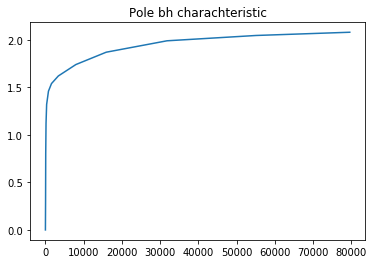

In [25]:
opti_mag()
grp_list = []
a = lamella(x0=-1, width=0.01,groups_list= grp_list)
b = lamella(x0=1, width=0.01,groups_list= grp_list)

In [28]:
while b.left[0][0] - a.right[0][0] < 0.2:
    a.move_boundary(0.1,0,1)
else:
    a = a+b

In [31]:
b.left[0][0]

0.995

In [32]:
a.right[0][0]

1.005

In [29]:
b.left[0][0] - a.right[0][0]

-0.009999999999999898

In [33]:
print(a)

left_edge:[-1.005, 0.5]<- x0:0.0-> right_edge:[1.005, 0.5] 
[-1.005, -0.5]     right_edge:[1.005, -0.5]


In [34]:
print(b)

left_edge:[0.995, 0.5]<- x0:1-> right_edge:[1.005, 0.5] 
[0.995, -0.5]     right_edge:[1.005, -0.5]


In [19]:
a = a+b

In [20]:
print(a)

left_edge:[-3.5, 0.5]<- x0:-2.0-> right_edge:[-0.7, 0.5] 
[-3.5, -0.5]     right_edge:[-0.7, -0.5]


In [22]:
a.move_boundary(1)

In [ ]:
def move_boundary(self, dx=0,dy=0, side=False):
    # side False is left side True is right side 
    
    if side:
        grp = 'left_group'
        __outer = 0
        dx *=-1
    else:
        grp = 'right_group'
        __outer = 1
        
    femm.mi_selectlabel(*self.outer[__outer])
    femm.mi_seteditmode('blocks')
    femm.mi_movetranslate(dx,dy)
    femm.mi_clearselected()
    
    femm.mi_selectgroup(self.__dict__[grp])
    femm.mi_seteditmode('nodes')
    femm.mi_movetranslate(dx,dy)
    femm.mi_clearselected()
    
    

In [ ]:



# Now,analyze the problem and load the solution when the analysis is finished
femm.mi_analyze()
femm.mi_loadsolution()

# If we were interested in the flux density at specific positions, 
# we could inquire at specific points directly:
b0=femm.mo_getb(0,0);
print('Flux density at the center of the bar is %g T' % b0[1]);
b1=femm.mo_getb(0,50);
print('Flux density at r=0,z=50 is %g T' % b1[1]);

# The program will report the terminal properties of the circuit:
# current, voltage, and flux linkage 
vals = femm.mo_getcircuitproperties('icoil');

# [i, v, \[Phi]] = MOGetCircuitProperties["icoil"]

# If we were interested in inductance, it could be obtained by
# dividing flux linkage by current
L = 1000*vals[2]/vals[0];
print('The self-inductance of the coil is %g mH' % L);

# Or we could, for example, plot the results along a line using 
zee=[]
bee=[]
for n in range(-100,101):
	b=femm.mo_getb(0,n);
	zee.append(n)
	bee.append(b[1]);

plt.plot(zee,bee)
plt.ylabel('Flux Density, Tesla')
plt.xlabel('Distance along the z-axis, mm')
plt.title('Plot of flux density along the axis')
plt.show()


In [124]:
femm.closefemm()

In [7]:
from math import sin,cos,pi,radians, degrees, atan2, hypot
class coil:
    def __init__(self,*arg):
        
        self.coil_dict={}
        if len(arg)==6:
            self.x0=arg[0]
            self.y0=arg[1]
            self.height=arg[2]
            self.in_diameter=arg[3]
            self.thickness=arg[4]
            self.shift_y=arg[5]/2
            
            
   
        
    def set_thickness(self,thickness=2.3,coil_name='coil_0'): # most COMPLETE
        
        if thickness >0:
            
            for start,end in zip( [2,3,4,5],[0,1,6,7]):
                for coil_type in self.coil_dict[coil_name]['coil_type']:
                    r,angle=self.get_angle_r( *self.coil_dict[coil_name][coil_type][start],
                                      *self.coil_dict[coil_name][coil_type][end]) 
                    new_x=self.coil_dict[coil_name][coil_type][start][0]+thickness*cos(angle) 
                    new_y=self.coil_dict[coil_name][coil_type][start][1]+thickness*sin(angle) 
                    x,y=self.coil_dict[coil_name][coil_type][end]
                    self.coil_dict[coil_name][coil_type][end]=[new_x,new_y]
                    # For different solver change command system, getDP and etc
                    femm.mi_selectnode(x,y)
                    femm.mi_deleteselectednodes()#femm.mi_movetranslate2(new_x-x,new_y-y,0)
                    femm.mi_clearselected()
            femm.mi_refreshview()
            
            self.draw_lines(coil_name)
            self.centering_label(coil_name)
            
            self.coil_dict[coil_name]['thickness']=thickness
            
        else: return 'Wrong parameter'
    
                
    def set_height(self,height=2.3,coil_name='coil_0'): # most COMPLETE
        
        for start,end,coil_type in [(i,j,k) for i,j,k in zip( [1,3,5,7,0,2,4,6],[0,2,4,6,1,3,5,7],['niedriger']*4+['oben']*4) if k in self.coil_dict[coil_name]['coil_type'] ]:
                       
                r,angle=self.get_angle_r( *self.coil_dict[coil_name][coil_type][start],
                                  *self.coil_dict[coil_name][coil_type][end]) 
                 
                new_x=self.coil_dict[coil_name][coil_type][start][0]+height*cos(angle) 
                new_y=self.coil_dict[coil_name][coil_type][start][1]+height*sin(angle) 
                x,y=self.coil_dict[coil_name][coil_type][end]
                self.coil_dict[coil_name][coil_type][end]=[new_x,new_y]
                
                # For different solver change command system, getDP and etc
                
                femm.mi_selectnode(x,y)
                femm.mi_deleteselectednodes()#femm.mi_movetranslate2(new_x-x,new_y-y,0)
                femm.mi_clearselected()
        femm.mi_refreshview()     
        self.coil_dict[coil_name]['height']=height 
        self.draw_lines(coil_name)
        self.centering_label(coil_name)          
              
        
    def set_diameter(self,in_diameter=2.3,coil_name='coil_0'):
        
        
        _,angle=self.get_angle_r(*self.coil_dict[coil_name]['oben'][2],
                                 *self.coil_dict[coil_name]['oben'][4])
        dr=0.5*self.coil_dict[coil_name]['in_diameter']-in_diameter
        dx=dr*cos(angle)
        dy=dr*sin(angle)
         
        for point,sign,coil_type in [(i,j,h) for i,j in zip([i for i in range(8)],[1]*4+[-1]*4) for h in self.coil_dict[coil_name]['coil_type']]:
                x,y=self.coil_dict[coil_name][coil_type][point]
                self.coil_dict[coil_name][coil_type][point]=[x+sign*dx,y+sign*dy]
                 #*****#*****************************#******#
               
                femm.mi_selectnode(x,y)
                femm.mi_deleteselectednodes()
                femm.mi_refreshview()
        self.coil_dict[coil_name]['in_diameter']=in_diameter      
        self.draw_lines(coil_name)
        self.centering_label(coil_name)
        
        
        
        
    def move(self,dx,dy,coil_name='coil_0'):
        print('move')
        for coil_type in self.coil_dict[coil_name]['coil_type']:
            for coord,point in enumerate(self.coil_dict[coil_name][coil_type][:-2]):
                
                femm.mi_selectnode(*point)
                
                femm.mi_deleteselectednodes()
                femm.mi_refreshview()
                self.coil_dict[coil_name][coil_type][coord]=[prev+dxy for prev,dxy in zip(point,[dx,dy])]
                
        self.draw_lines(coil_name)   
        self.centering_label(coil_name)
        
        
    def centering_label(self,coil_name='coil_0'):
        
        for start,end,previos_coord,coil_type in [(a,b,c,d) for a,b,c, in zip([0,4],[3,7],[-2,-1]) for d in self.coil_dict[coil_name]['coil_type']]:
        
        
            x1,y1=self.coil_dict[coil_name][coil_type][start]
            x2,y2=self.coil_dict[coil_name][coil_type][end]
            x,y=self.coil_dict[coil_name][coil_type][previos_coord]
            new_x=((x2-x1)/2)+x1
            new_y=((y2-y1)/2)+y1   
            dx=new_x-x
            dy=new_y-y 
            #*******femm implementation*****
            femm.mi_selectlabel(x,y)
            femm.mi_movetranslate2(dx,dy,2)
            femm.mi_refreshview() 
            #******************************
            self.coil_dict[coil_name][coil_type][previos_coord]=[new_x,new_y]   
            
    def rot_via_point(self,coil_name,angle,x0='none',y0='none'):
        angle=radians(angle)
        if x0==y0=='none':
            x0,y0=self.coil_dict[coil_name]['base']
        for coil_type in self.coil_dict[coil_name]['coil_type']:           
            for position,(x,y) in enumerate(self.coil_dict[coil_name][coil_type][:-2]):
                r, t_angle=self.get_angle_r(x0,y0,x,y)   
                if r:
                    new_x=x0+r*cos(angle+t_angle)
                    new_y=y0+r*sin(angle+t_angle)
                    femm.mi_selectnode(x,y)
                    femm.mi_deleteselectednodes()
                    femm.mi_refreshview()
                    self.coil_dict[coil_name][coil_type][position]=[new_x,new_y]
        self.draw_lines(coil_name)
        self.centering_label(coil_name)
        
    def set_angle(self,coil_name,angle,x0='none',y0='none'):
        angle=radians(angle)
        if x0==y0=='none':
            x0,y0=self.coil_dict[coil_name]['base']
        x=self.coil_dict[coil_name][coil_type][0]  
        y=self.coil_dict[coil_name][coil_type][2]
        r,angle_real=self.get_angle_r(*x,*y) 
        n_angle=eangle-angle_real
        for coil_type in self.coil_dict[coil_name]['coil_type']:           
            for position,(x,y) in enumerate(self.coil_dict[coil_name][coil_type][:-2]):
                r, _=self.get_angle_r(x0,y0,x,y)   
                if r:
                    new_x=x0+r*cos(n_angle)
                    new_y=y0+r*sin(n_angle)
                    femm.mi_selectnode(x,y)
                    femm.mi_deleteselectednodes()
                    femm.mi_refreshview()
                    self.coil_dict[coil_name][coil_type][position]=[new_x,new_y]
        self.draw_lines(coil_name)
        self.centering_label(coil_name)
            
        
    def calculate_coil_coordinates(self,x0=0,y0=0,height=1,in_diameter=1,thickness=1):
        
        '''From left-low edge of figure'''
        point_array=[
            [x0,y0], [x0,y0+height],
            [x0+thickness,y0],[x0+thickness,y0+height],
            [x0+thickness+in_diameter,y0],[x0+thickness+in_diameter,y0+height],
            [x0+2*thickness+in_diameter,y0],[x0+2*thickness+in_diameter,y0+height]]
        property_labels=[[x0+0.5*thickness,y0+0.5*height],
             [x0+1.5*thickness+in_diameter,y0+0.5*height]]
        return point_array+property_labels
        
    def draw_lines(self,coil_name):
        
            for i,j in zip([0,2,4,6,1,5,0,4], [1,3,5,7,3,7,2,6]):
                for coil_type in self.coil_dict[coil_name]['coil_type']:
                    femm.mi_drawline(*self.coil_dict[coil_name][coil_type][i],
                                     *self.coil_dict[coil_name][coil_type][j])
            for coil_type in self.coil_dict[coil_name]['coil_type']:        
                for coordinates in self.coil_dict[coil_name][coil_type][-2:]:
                    femm.mi_addblocklabel(*coordinates)
            
   
    
   
    
    def get_angle_r(self,x0,y0,x,y):
        x=x-x0
        y=y-y0
        r =  hypot (x,y)#round(((x-x0)**2 + (y-y0)**2)**0.5,4)
        angle=0
        angle=atan2(y,x)
        
            
        #try:
            #if y0-y<0:  angle=acos((x-x0)/r)
            #if y0-y>0:  angle=2*pi-acos((x-x0)/r)
        #except ValueError:
            #print(f'\'y{y0-y}, x{x-x0},r{r}')
           
        return r, angle
        
    def create_coil(self,*arg,coil_type='dual'):
        if len(arg) != 6  : 
            print(f' Need more arguments:\n x0 ,y0; height; in_diameter; thickness; distance')
        else:
            x0=arg[0]
            y0=arg[1]
            height=arg[2]
            in_diameter=arg[3]
            thickness=arg[4]
            distance=arg[5]
            shift_y=distance/2

            coil_prop = [[x0-(thickness+in_diameter/2),y0+shift_y],
                         [x0-(thickness+in_diameter/2),y0-shift_y-height]]
            coil_prop[0]+=arg[2:5]
            coil_prop[1]+=arg[2:5]
            coil_name=f'coil_{len(self.coil_dict)}'
            self.coil_dict.update({coil_name:{
                'coil_type'  :['oben','niedriger'],# if dual coil [oben,niedriger] else [oben] 
                'base'       :[x0,y0],
                'height'     :height,
                'in_diameter':in_diameter,
                'thickness'  :thickness,
                'distance'   :distance,
                'oben'       :self.calculate_coil_coordinates(*coil_prop[0]),
                'niedriger'  :self.calculate_coil_coordinates(*coil_prop[1]),
                'current'    :0,
                'turns'      :1,
                'circuit'    :'Circuit_coil'
                }})
            
            self.draw_lines(coil_name)
    def set_property(self,value,prop):
        if value>0:
            pass
            
        
                
    def GOST(self):
        pass # iterator 
    def ieee(self):
        pass # iterator
    
    def test_form(self,coil_name='coil_0'):
        
           
        
        height=self.coil_dict[coil_name]['height']
        thickness=self.coil_dict[coil_name]['thickness']
        for coil_type in self.coil_dict[coil_name]['coil_type']:
            for start,end in zip([0,2,4,6],[1,3,5,7]):
                height_real,_=self.get_angle_r( *self.coil_dict[coil_name][coil_type][start],
                                          *self.coil_dict[coil_name][coil_type][end]) 
                if height_real == height: 
                    pass
                else:
                    print('alarm height',start,end,coil_type)
                    print(height_real , height)
                    return False
                    break

            for start_end in zip([0,1,4,5],[2,3,6,7]):
                thickness_real,_=self.get_angle_r( *self.coil_dict[coil_name][coil_type][start],
                                          *self.coil_dict[coil_name][coil_type][end]) 
                if thickness_real == thickness: 
                    pass
                else: 
                    print('alarm thickness ',start,end,coil_type)
                    print(thickness_real, thickness)
                    return False
                    break
        return True
            

In [8]:
def ar(x0,y0,x,y):
        r = round(((x-x0)**2 + (y-y0)**2)**0.5,4)
        x=x-x0
        y=y-y0
        angle=atan2(y,x)
        return r, angle
vec=[1,2,3,3]
femm.mi_drawline(*vec)
time.sleep(0.001)
_,angle=ar(*vec)
print(f'{r*cos(angle)}  {r*sin(angle)}')
for grad in vs(range(360)):
    time.sleep(0.001)
    r,rot=ar(*vec)
    angle+=radians(1)
    vec[2]=vec[0]+r*cos(angle)
    vec[3]=vec[1]+r*sin(angle)
    
    femm.mi_drawline(*vec)
print(vec)    

0.0010917875251164944  0.0005458937625582472


A Jupyter Widget


[1, 2, 3.0000286417949638, 3.0000143208973524]


In [52]:
global HandleToFEMM

Flux density at the center of the bar is 0.504432 T
Flux density at r=0,z=50 is 0.053487 T
The self-inductance of the coil is 4.37673 mH


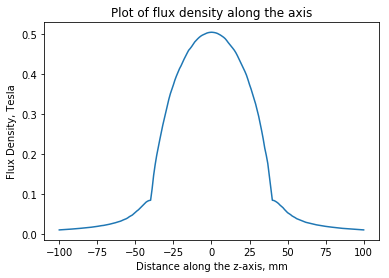

In [26]:
import femm
import matplotlib.pyplot as plt

# The package must be initialized with the openfemm command.
femm.openfemm()

# We need to create a new Magnetostatics document to work on.
femm.newdocument(0)

# Define the problem type.  Magnetostatic; Units of mm; Axisymmetric; 
# Precision of 10^(-8) for the linear solver; a placeholder of 0 for 
# the depth dimension, and an angle constraint of 30 degrees
femm.mi_probdef(0, 'millimeters', 'axi', 1.e-8, 0, 30);

# Draw a rectangle for the steel bar on the axis;
femm.mi_drawrectangle(0, -40, 10, 40);

# Draw a rectangle for the coil;
femm.mi_drawrectangle(50, -50, 100, 50);

# Define an "open" boundary condition using the built-in function:
femm.mi_makeABC()

# Add block labels, one to each the steel, coil, and air regions.
femm.mi_addblocklabel(5,0);
femm.mi_addblocklabel(75,0);
femm.mi_addblocklabel(30,100);

# Add some block labels materials properties
femm.mi_addmaterial('Air', 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0);
femm.mi_addmaterial('Coil', 1, 1, 0, 0, 58*0.65, 0, 0, 1, 0, 0, 0);
femm.mi_addmaterial('LinearIron', 2100, 2100, 0, 0, 0, 0, 0, 1, 0, 0, 0);

# A more interesting material to add is the iron with a nonlinear
# BH curve.  First, we create a material in the same way as if we 
# were creating a linear material, except the values used for 
# permeability are merely placeholders.

femm.mi_addmaterial('Iron', 2100, 2100, 0, 0, 0, 0, 0, 1, 0, 0, 0);

# A set of points defining the BH curve is then specified.
bdata = [ 0.,0.3,0.8,1.12,1.32,1.46,1.54,1.62,1.74,1.87,1.99,2.046,2.08]; 
hdata = [ 0, 40, 80, 160, 318, 796, 1590, 3380, 7960, 15900, 31800, 55100, 79600];
for n in range(0,len(bdata)):
	femm.mi_addbhpoint('Iron', bdata[n],hdata[n]);

# Add a "circuit property" so that we can calculate the properties of the
# coil as seen from the terminals.
femm.mi_addcircprop('icoil', 20, 1);

# Apply the materials to the appropriate block labels
femm.mi_selectlabel(5,0);
femm.mi_setblockprop('Iron', 0, 1, '<None>', 0, 0, 0);
femm.mi_clearselected()

femm.mi_selectlabel(75,0);
femm.mi_setblockprop('Coil', 0, 1, 'icoil', 0, 0, 200);
femm.mi_clearselected()

femm.mi_selectlabel(30,100);
femm.mi_setblockprop('Air', 0, 1, '<None>', 0, 0, 0);
femm.mi_clearselected()

# Now, the finished input geometry can be displayed.
femm.mi_zoomnatural()

# We have to give the geometry a name before we can analyze it.
femm.mi_saveas('coil.fem');


# Now,analyze the problem and load the solution when the analysis is finished
femm.mi_analyze()
femm.mi_loadsolution()

# If we were interested in the flux density at specific positions, 
# we could inquire at specific points directly:
b0=femm.mo_getb(0,0);
print('Flux density at the center of the bar is %g T' % b0[1]);
b1=femm.mo_getb(0,50);
print('Flux density at r=0,z=50 is %g T' % b1[1]);

# The program will report the terminal properties of the circuit:
# current, voltage, and flux linkage 
vals = femm.mo_getcircuitproperties('icoil');

# [i, v, \[Phi]] = MOGetCircuitProperties["icoil"]

# If we were interested in inductance, it could be obtained by
# dividing flux linkage by current
L = 1000*vals[2]/vals[0];
print('The self-inductance of the coil is %g mH' % L);

# Or we could, for example, plot the results along a line using 
zee=[]
bee=[]
for n in range(-100,101):
	b=femm.mo_getb(0,n);
	zee.append(n)
	bee.append(b[1]);

plt.plot(zee,bee)
plt.ylabel('Flux Density, Tesla')
plt.xlabel('Distance along the z-axis, mm')
plt.title('Plot of flux density along the axis')
plt.show()

# When the analysis is completed, FEMM can be shut down.
femm.closefemm()



In [13]:
import win32com.client
FEMMDoc = win32com.client.Dispatch("femm.ActiveFEMM");

Alg=[
    'newdocument(0)',
    "mi_probdef(Freq, 'millimeters', 'planar', 1.e-10, 1.405, 50)",
    "mi_addmaterial('Air', 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0)",
    "mi_addmaterial('Coil', 1, 1, 0, 0, Cupper_cond, 0, 0, 0, 4,0,0, n_lam, d_coil)",
    "mi_addmaterial('MSM_Compr', 6.9, 6.9, 0, 0, 0, 0, 0, 1, 0, 0, 0)",
    "mi_addmaterial('MSM_Stret', 2.22, 2.22, 0, 0, 0, 0, 0, 1, 0, 0, 0)"
    
]
[FEMMDoc.call2femm(Alg[i]) for i,text in enumerate(Alg)]
rec = lambda x0,y0,x,y:FEMMDoc.call2femm("mi_drawrectangle({0},{1},{2},{3})".format(x0,y0,x,y))
label = lambda x0,y0: FEMMDoc.call2femm("mi_addblocklabel({0},{1})".format(x0,y0))
selectlabel= lambda x0,y0: FEMMDoc.call2femm("mi_selectlabel({0},{1})".format(x0,y0))
setlabel =lambda typ,cir,N :FEMMDoc.call2femm("mi_setblockprop({0}, 0, 1, {1}, 0, 0, {2})".format(typ,cir,N))
circuit=lambda CirName,Current,ConType=1:FEMMDoc.call2femm("mi_addcircprop({0}, {1}, {2})".format(CirName,Current,ConType))

def free():
    FEMMDoc.call2femm("mi_clearselected()")
    FEMMDoc.call2femm("mi_refreshview()")

def cir(x,y,r,angle=180):
    FEMMDoc.call2femm("mi_drawarc({0},{1},{0},{2},{3},1)".format(x,y-r,y+r),angle)
    FEMMDoc.call2femm("mi_drawarc({0},{1},{0},{2},{3},1)".format(x,y+r,y-r),angle)
    
def mat(x,y,mtype,cir=0,N=0):
    label(x,y)
    selectlabel(x,y)
    FEMMDoc.call2femm("mi_setblockprop({0}, 0, 1, {1}, 0, 0, {2})".format(mtype,cir,N))
    free()
    
def coil(x,y,a=1,b=1,c=1,N=1,d=1, cir=1, mat='Air'):
    circuit(cir,0)
    rec(x,y,x+a,y+b)
    rec(x+a+c,y,x+2*a+c,y+b)
    #Coils
    label(x+a/2,y+b/2)
    selectlabel(x+a/2,y+b/2)
    setlabel(mat,cir,N)
    free()
    
    label(x+a*1.5+c,y+b*0.5)
    selectlabel(x+a*1.5+c,y+b/2)
    setlabel(mat,cir,-N)
    free()
    
#def rectangle(x_pos,y_pos,width,height):
coil(-1,0,cir= "MC",mat="Coil")

circuit("12",100,1)
del FEMMDoc # закрыть фемм

In [12]:
for i in range(10):
    
    if i & 0b0000010: print(bin(i))
    else:print('  ',bin(i))

   0b0
   0b1
0b10
0b11
   0b100
   0b101
0b110
0b111
   0b1000
   0b1001


In [165]:
class test:
    def __init__(self, a=[]):
        if not a:
            print('new')
            a += [0,1]
            #a = [0,1] # Кованая дичь , не работает из-за того,
            #что имя 'a' присваивается локальному обьекту
        else:
            print('add')
            a+=[len(a)]   
a =[]
[test(a) for _ in range(5)]
print(a)


new
add
add
add
add
[0, 1, 2, 3, 4, 5]
